<a href="https://colab.research.google.com/github/PadawanXXVI/spotify-data-storytelling/blob/main/spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎓 Spotify Data Storytelling — Semana 2  
## Coleta, Limpeza e Transformação de Dados

**Curso:** Tecnologia em Ciência de Dados — Faculdade de Tecnologia e Inovação Senac DF  
**Professor:** Alexsander Holanda Barreto  
**Autor:** Anderson de Matos Guimarães  

---

### 🎯 Objetivo da Semana 2
Esta etapa foca na **coleta via API do Spotify**, seguida por **limpeza, transformação e análise exploratória inicial**.  
O resultado final será um **dataset tratado (`spotify_semana2_tratado.csv`)** e um **relatório parcial** descrevendo metodologia e insights.

---

### 🧩 Etapas desta semana
1. Instalação e importação de bibliotecas.  
2. Autenticação segura na API.  
3. Coleta de faixas por gêneros brasileiros.  
4. Diagnóstico e inspeção inicial.  
5. Limpeza, padronização e criação de colunas derivadas.  
6. Exportação dos datasets bruto e tratado.  
7. Geração do relatório parcial.


In [ ]:
# 🛠️ Instalação da biblioteca Spotipy (interface oficial da API do Spotify)
!pip install spotipy --quiet

print("✅ Spotipy instalada com sucesso!")


✅ Spotipy instalada com sucesso!


In [ ]:
# ⚙️ Importação de bibliotecas necessárias
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from datetime import datetime

print("✅ Bibliotecas importadas com sucesso!")


✅ Bibliotecas importadas com sucesso!


## 🔐 Autenticação Segura na API do Spotify  

Para garantir segurança e reprodutibilidade, as credenciais ficam armazenadas em variáveis de ambiente:  
- `SPOTIPY_CLIENT_ID`  
- `SPOTIPY_CLIENT_SECRET`  

Essas chaves são obtidas no [Spotify Developer Dashboard](https://developer.spotify.com/dashboard).


In [ ]:
# 🔐 Autenticação segura usando secrets do Google Colab
from google.colab import userdata
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# 🔎 Recupera as chaves armazenadas em "Secrets"
client_id = userdata.get('SPOTIPY_CLIENT_ID')
client_secret = userdata.get('SPOTIPY_CLIENT_SECRET')

# ✅ Teste de autenticação
try:
    auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(auth_manager=auth_manager)
    sp.search(q="genre:pop", type="track", limit=1)
    print("🎧 Autenticação realizada com sucesso via Colab Secrets!")
except Exception as e:
    print(f"❌ Falha na autenticação: {e}")


🎧 Autenticação realizada com sucesso via Colab Secrets!


In [ ]:
# 🌎 Descoberta automática de categorias Spotify (Brasil)
print("🔎 Coletando categorias disponíveis no Spotify Brasil...")

# Busca até 50 categorias disponíveis
categorias_data = sp.categories(country="BR", limit=50)
categorias = {c["name"]: c["id"] for c in categorias_data["categories"]["items"]}

print(f"✅ Total de categorias encontradas: {len(categorias)}\n")
print("📋 Categorias disponíveis no Brasil:")
for nome in categorias.keys():
    print("-", nome)

# 🧩 Filtra categorias claramente musicais
categorias_musicais = [
    c for c in categorias.keys()
    if any(x in c.lower() for x in [
        "pop", "rock", "hip", "r&b", "dance", "latin", "metal", "jazz",
        "soul", "folk", "acoustic", "instrumental", "electronic",
        "country", "alternative", "blues", "gospel", "indie", "k-pop",
        "mpb", "sertanejo", "forró", "funk", "samba", "pagode"
    ])
]

print(f"\n🎶 Categorias musicais identificadas automaticamente ({len(categorias_musicais)}):")
print(categorias_musicais)

# 🔁 Substitui a lista manual de gêneros pela automática
generos_validos = categorias_musicais


🔎 Coletando categorias disponíveis no Spotify Brasil...
✅ Total de categorias encontradas: 50

📋 Categorias disponíveis no Brasil:
- Made For You
- New Releases
- Hip-Hop
- Country
- Pop
- Latin
- Charts
- Rock
- R&B
- Dance/Electronic
- Indie
- Fall
- Workout
- Mood
- Party
- Student
- Love
- Disney
- Netflix
- Chill
- Sleep
- Discover
- Jazz
- Metal
- Christian & Gospel
- Música Mexicana
- Happy Holidays
- Classical
- Decades
- Kids & Family
- In the car
- At Home
- EQUAL
- Spotify CLASSICS
- GLOW
- Frequency
- TV & Movies
- Trending
- Folk & Acoustic
- K-pop
- Punk
- Blues
- Soul
- Alternative
- Anime
- Instrumental
- RADAR
- Fresh Finds
- Songwriters
- Spotify Singles

🎶 Categorias musicais identificadas automaticamente (17):
['Hip-Hop', 'Country', 'Pop', 'Latin', 'Rock', 'R&B', 'Dance/Electronic', 'Indie', 'Jazz', 'Metal', 'Christian & Gospel', 'Folk & Acoustic', 'K-pop', 'Blues', 'Soul', 'Alternative', 'Instrumental']


In [ ]:
# 🎧 Coleta automática de faixas musicais via API do Spotify (Brasil)

# 1️⃣ Lista de categorias musicais definidas dinamicamente
generos_validos = categorias_musicais
print(f"🎯 Total de gêneros a serem coletados: {len(generos_validos)}\n")

# 2️⃣ Estruturas de armazenamento
all_tracks = []
resumo = []

# 3️⃣ Loop de coleta
for genero in generos_validos:
    print(f"🎶 Buscando faixas da categoria: {genero}")
    try:
        results = sp.search(q=f"genre:{genero}", type="track", limit=50, market="BR")
        tracks = results["tracks"]["items"]

        # Caso nenhuma faixa seja encontrada
        if len(tracks) == 0:
            print(f"⚠️ Nenhum resultado encontrado para: {genero}")
            continue

        # Paginação — coleta até 500 resultados por categoria
        offset = 50
        while results["tracks"]["next"] and offset < 500:
            results = sp.next(results["tracks"])
            tracks.extend(results["tracks"]["items"])
            offset += 50

        # Estruturação dos dados
        for item in tracks:
            all_tracks.append({
                "genero": genero,
                "faixa": item["name"],
                "artista": item["artists"][0]["name"],
                "album": item["album"]["name"],
                "data_lancamento": item["album"]["release_date"],
                "popularidade": item["popularity"],
                "duracao_ms": item["duration_ms"]
            })

        resumo.append({"genero": genero, "qtd_faixas": len(tracks)})
        print(f"✅ {len(tracks)} faixas coletadas para {genero}")

    except Exception as e:
        print(f"❌ Erro ao coletar gênero {genero}: {e}")

# 4️⃣ Consolidação em DataFrame
df_raw = pd.DataFrame(all_tracks)
df_resumo = pd.DataFrame(resumo).sort_values("qtd_faixas", ascending=False)

print("\n📊 Resumo da coleta por gênero:")
display(df_resumo)

# 5️⃣ Exportação do dataset bruto
os.makedirs("/content/data", exist_ok=True)
df_raw.to_csv("/content/data/spotify_raw.csv", index=False)
print(f"💾 Dataset bruto exportado com sucesso! {len(df_raw)} faixas salvas em /content/data/spotify_raw.csv")


🎯 Total de gêneros a serem coletados: 17

🎶 Buscando faixas da categoria: Hip-Hop
✅ 100 faixas coletadas para Hip-Hop
🎶 Buscando faixas da categoria: Country
✅ 100 faixas coletadas para Country
🎶 Buscando faixas da categoria: Pop
✅ 100 faixas coletadas para Pop
🎶 Buscando faixas da categoria: Latin
✅ 100 faixas coletadas para Latin
🎶 Buscando faixas da categoria: Rock
✅ 100 faixas coletadas para Rock
🎶 Buscando faixas da categoria: R&B
✅ 100 faixas coletadas para R&B
🎶 Buscando faixas da categoria: Dance/Electronic
✅ 100 faixas coletadas para Dance/Electronic
🎶 Buscando faixas da categoria: Indie
✅ 100 faixas coletadas para Indie
🎶 Buscando faixas da categoria: Jazz
✅ 100 faixas coletadas para Jazz
🎶 Buscando faixas da categoria: Metal
✅ 100 faixas coletadas para Metal
🎶 Buscando faixas da categoria: Christian & Gospel
✅ 100 faixas coletadas para Christian & Gospel
🎶 Buscando faixas da categoria: Folk & Acoustic
✅ 100 faixas coletadas para Folk & Acoustic
🎶 Buscando faixas da categoria

,genero,qtd_faixas
0,Hip-Hop,100
1,Country,100
2,Pop,100
3,Latin,100
4,Rock,100
5,R&B,100
6,Dance/Electronic,100
7,Indie,100
8,Jazz,100
9,Metal,100


💾 Dataset bruto exportado com sucesso! 1700 faixas salvas em /content/data/spotify_raw.csv


## 🧹 Fase 2 — Limpeza e Transformação dos Dados (Semana 2)

Nesta etapa, realizamos o tratamento do dataset coletado pela API do Spotify.
As principais tarefas incluem:
- Verificar a integridade dos dados (ausentes, duplicados e tipos inconsistentes);
- Corrigir formatações de datas e durações;
- Normalizar variáveis numéricas;
- Exportar a base tratada para as análises exploratórias da próxima semana.

Esta fase é crucial para garantir **qualidade, consistência e confiabilidade** na análise de dados musicais.


In [ ]:
# 📂 Importa o dataset bruto salvo na fase anterior
import pandas as pd

df_raw = pd.read_csv("/content/data/spotify_raw.csv")

print(f"✅ Dataset carregado com sucesso: {df_raw.shape[0]} linhas × {df_raw.shape[1]} colunas")
display(df_raw.head())


✅ Dataset carregado com sucesso: 1700 linhas × 7 colunas


,genero,faixa,artista,album,data_lancamento,popularidade,duracao_ms
0,Hip-Hop,Shdy Nate Intro,Shady Nate,The Shady Bunch Vol. 2,2010-01-30,0,37933
1,Hip-Hop,KEILING FANS,Mo Money,MASTER MIND,2022-07-01,0,177345
2,Hip-Hop,Blap That Ass Up,Paris,Acid Reflex (Radio Safe Version),2008-10-28,0,281426
3,Hip-Hop,Com' On,Bo,Without Borders,2010-10-10,0,249533
4,Hip-Hop,Съзнание,Hoodini,На аванта I,2016-05-05,0,189333


In [ ]:
# 🔍 Estrutura geral e estatísticas básicas
print("📋 Estrutura do dataset bruto:")
print()
print(f"Dimensões: {df_raw.shape[0]} linhas × {df_raw.shape[1]} colunas\n")
print(df_raw.info())
print("\n📈 Estatísticas descritivas iniciais:")
display(df_raw.describe(include='all'))


📋 Estrutura do dataset bruto:

Dimensões: 1700 linhas × 7 colunas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   genero           1700 non-null   object
 1   faixa            1700 non-null   object
 2   artista          1700 non-null   object
 3   album            1700 non-null   object
 4   data_lancamento  1700 non-null   object
 5   popularidade     1700 non-null   int64 
 6   duracao_ms       1700 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 93.1+ KB
None

📈 Estatísticas descritivas iniciais:


,genero,faixa,artista,album,data_lancamento,popularidade,duracao_ms
count,1700,1700,1700,1700,1700,1700.000000,1700.000000
unique,17,1480,839,1284,1030,NaN,NaN
top,Hip-Hop,Hit the Road Jack,Linkin Park,The Life of a Showgirl + Acoustic Collection,2025-10-31,NaN,NaN
freq,100,4,35,14,22,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,54.124706,220635.817647
std,NaN,NaN,NaN,NaN,NaN,32.098010,81499.195608
min,NaN,NaN,NaN,NaN,NaN,0.000000,15270.000000
25%,NaN,NaN,NaN,NaN,NaN,35.750000,169900.250000
50%,NaN,NaN,NaN,NaN,NaN,68.000000,209468.500000
75%,NaN,NaN,NaN,NaN,NaN,77.000000,252176.500000


In [ ]:
# 🧼 Limpeza e padronização
df = df_raw.copy()

# 1️⃣ Remover duplicatas
df.drop_duplicates(subset=["faixa", "artista", "album"], inplace=True)

# 2️⃣ Corrigir formato de data
df["data_lancamento"] = pd.to_datetime(df["data_lancamento"], errors="coerce")

# 3️⃣ Converter duração para minutos
df["duracao_min"] = (df["duracao_ms"] / 60000).round(2)

# 4️⃣ Normalizar a popularidade entre 0 e 1
df["popularidade_norm"] = df["popularidade"] / 100

# 5️⃣ Remover linhas com dados ausentes críticos
df.dropna(subset=["genero", "faixa", "artista", "album"], inplace=True)

print("✅ Limpeza concluída. Estrutura atualizada:")
print(df.info())


✅ Limpeza concluída. Estrutura atualizada:
<class 'pandas.core.frame.DataFrame'>
Index: 1539 entries, 0 to 1699
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genero             1539 non-null   object        
 1   faixa              1539 non-null   object        
 2   artista            1539 non-null   object        
 3   album              1539 non-null   object        
 4   data_lancamento    1458 non-null   datetime64[ns]
 5   popularidade       1539 non-null   int64         
 6   duracao_ms         1539 non-null   int64         
 7   duracao_min        1539 non-null   float64       
 8   popularidade_norm  1539 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 120.2+ KB
None


In [ ]:
# 🧾 Diagnóstico final
print("🩶 Valores nulos restantes por coluna:")
print(df.isna().sum())

print("\n📊 Estatísticas descritivas após tratamento:")
display(df.describe(include='all'))


🩶 Valores nulos restantes por coluna:
genero                0
faixa                 0
artista               0
album                 0
data_lancamento      81
popularidade          0
duracao_ms            0
duracao_min           0
popularidade_norm     0
dtype: int64

📊 Estatísticas descritivas após tratamento:


,genero,faixa,artista,album,data_lancamento,popularidade,duracao_ms,duracao_min,popularidade_norm
count,1539,1539,1539,1539,1458,1539.000000,1539.000000,1539.000000,1539.000000
unique,17,1480,839,1284,NaN,NaN,NaN,NaN,NaN
top,Hip-Hop,The Fate of Ophelia,Taylor Swift,DeBÍ TiRAR MáS FOToS,NaN,NaN,NaN,NaN,NaN
freq,100,4,28,14,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,2014-02-17 10:58:45.925925888,52.206628,222498.365172,3.708317,0.522066
min,NaN,NaN,NaN,NaN,1952-04-01 00:00:00,0.000000,15270.000000,0.250000,0.000000
25%,NaN,NaN,NaN,NaN,2009-09-20 18:00:00,0.000000,172409.500000,2.875000,0.000000
50%,NaN,NaN,NaN,NaN,2019-04-20 12:00:00,66.000000,210625.000000,3.510000,0.660000
75%,NaN,NaN,NaN,NaN,2024-02-14 18:00:00,77.000000,253399.500000,4.220000,0.770000
max,NaN,NaN,NaN,NaN,2025-11-13 00:00:00,100.000000,814600.000000,13.580000,1.000000


In [ ]:
# 💾 Exporta o dataset tratado
os.makedirs("/content/data", exist_ok=True)
df.to_csv("/content/data/spotify_semana2_tratado.csv", index=False)

print(f"💾 Dataset tratado salvo com sucesso em /content/data/spotify_semana2_tratado.csv ({df.shape[0]} registros)")


💾 Dataset tratado salvo com sucesso em /content/data/spotify_semana2_tratado.csv (1539 registros)


## 📊 Relatório Parcial — Semana 2 (Coleta, Limpeza e Transformação)

Nesta semana, foi realizada a coleta automática de **1.700 faixas musicais**
distribuídas em **17 gêneros**, por meio da API do Spotify (Spotipy).

O dataset passou por um processo de limpeza e transformação, com destaque para:
- Remoção de duplicatas e registros inconsistentes;
- Conversão da data de lançamento para formato `datetime`;
- Criação de colunas derivadas: duração em minutos e popularidade normalizada;
- Padronização dos tipos de dados para futura análise exploratória.

O dataset resultante, `spotify_semana2_tratado.csv`, está pronto para a **Fase 3 — Análise Exploratória e Visualização**, onde serão aplicadas técnicas estatísticas e gráficos para interpretar padrões musicais e comportamentos de consumo.


## 🚀 Próximos Passos (Semana 3 – Análise e Visualização)

Na próxima etapa, realizaremos:

- Análise exploratória (EDA) detalhada com Pandas, Seaborn e Plotly;
- Visualizações de distribuição de popularidade, duração e artistas mais frequentes;
- Correlações entre gêneros e popularidade média;
- Introdução de storytelling analítico assistido por IA (Engenharia de Prompt).

O objetivo é traduzir os dados tratados em **insights visuais e narrativas interpretativas** sobre o consumo musical no Brasil.


# 📊 Semana 3 — Análise Exploratória e Visualização (EDA)

Nesta etapa, vamos explorar o dataset tratado na Semana 2 e gerar visualizações
para padrões de **popularidade**, **duração** e **lançamentos por ano** (por gênero).


In [ ]:
# ============================================
# Célula 17 — Carga robusta + preparação inicial
# ============================================

import os
import pandas as pd
import numpy as np

# POSSÍVEIS CAMINHOS DO DATASET
possible_paths = [
    "/content/data/spotify_semana2_tratado.csv",
    "spotify_semana2_tratado.csv",
    "./data/spotify_semana2_tratado.csv",
]

csv_path = None
for p in possible_paths:
    if os.path.exists(p):
        csv_path = p
        break

if csv_path is None:
    raise FileNotFoundError(
        "❌ Não encontrei o arquivo 'spotify_semana2_tratado.csv' em nenhum caminho esperado.\n"
        "Verifique se a execução da Semana 2 gerou corretamente o arquivo na pasta /content/data/"
    )

print(f"📁 Carregando dataset: {csv_path}\n")

# CARREGAMENTO
df = pd.read_csv(csv_path)

# ==============================
# AJUSTES DE TIPOS
# ==============================

# Converte datas
df["data_lancamento"] = pd.to_datetime(df["data_lancamento"], errors="coerce")

# Cria atributo derivado — usado na Issue
df["ano_lancamento"] = df["data_lancamento"].dt.year

# Garante numéricos
df["duracao_min"] = pd.to_numeric(df["duracao_min"], errors="coerce")
df["popularidade"] = pd.to_numeric(df["popularidade"], errors="coerce")

# Limpeza básica (apenas para garantir integridade)
df = df.dropna(subset=["popularidade", "duracao_min", "ano_lancamento"])

# Confere intervalos anômalos de popularidade (0–100)
invalid_pop = df[(df["popularidade"] < 0) | (df["popularidade"] > 100)]
if not invalid_pop.empty:
    print("⚠ Popularidade fora do intervalo detectada. Removendo valores inválidos...")
    df = df[(df["popularidade"] >= 0) & (df["popularidade"] <= 100)]

# ==============================
# PREVIEW FINAL
# ==============================

print(f"✅ Dataset carregado com sucesso!")
print(f"➡ {df.shape[0]} linhas × {df.shape[1]} colunas")
display(df.head(3))

📁 Carregando dataset: /content/data/spotify_semana2_tratado.csv

✅ Dataset carregado com sucesso!
➡ 1458 linhas × 10 colunas


,genero,faixa,artista,album,data_lancamento,popularidade,duracao_ms,duracao_min,popularidade_norm,ano_lancamento
0,Hip-Hop,Shdy Nate Intro,Shady Nate,The Shady Bunch Vol. 2,2010-01-30,0,37933,0.63,0.0,2010.0
1,Hip-Hop,KEILING FANS,Mo Money,MASTER MIND,2022-07-01,0,177345,2.96,0.0,2022.0
2,Hip-Hop,Blap That Ass Up,Paris,Acid Reflex (Radio Safe Version),2008-10-28,0,281426,4.69,0.0,2008.0


In [ ]:
# ============================================
# Célula 18 — Diagnóstico inicial da base (EDA)
# ============================================

print("📌 ESTRUTURA DO DATAFRAME\n")
display(df.info())

print("\n📌 PREVIEW DAS PRIMEIRAS LINHAS\n")
display(df.head())

print("\n📌 PREVIEW DAS ÚLTIMAS LINHAS\n")
display(df.tail())

print("\n📌 ESTATÍSTICAS DESCRITIVAS (NUMÉRICAS)\n")
display(df.describe().T)

print("\n📌 ESTATÍSTICAS DESCRITIVAS (CATEGÓRICAS)\n")
display(df.describe(include='object').T)

print("\n📌 VALORES AUSENTES POR COLUNA\n")
display(df.isnull().sum())

print("\n📌 CARDINALIDADES\n")
print(f"🎧 Gêneros únicos: {df['genero'].nunique()}")
print(f"🎤 Artistas únicos: {df['artista'].nunique()}")
print(f"💿 Álbuns únicos: {df['album'].nunique()}")
print(f"📅 Anos de lançamento únicos: {df['ano_lancamento'].nunique()}")

print("\n📌 VERIFICAÇÃO DE DUPLICIDADES\n")
duplicates = df.duplicated().sum()
print(f"🔁 Registros duplicados: {duplicates}")

print("\n📌 LIMITES POTENCIAIS A INVESTIGAR\n")
print(f"→ Popularidade mínima: {df['popularidade'].min()}")
print(f"→ Popularidade máxima: {df['popularidade'].max()}")
print(f"→ Duração mínima (min): {df['duracao_min'].min():.2f}")
print(f"→ Duração máxima (min): {df['duracao_min'].max():.2f}")
print(f"→ Ano mínimo: {df['ano_lancamento'].min()}")
print(f"→ Ano máximo: {df['ano_lancamento'].max()}")

📌 ESTRUTURA DO DATAFRAME

<class 'pandas.core.frame.DataFrame'>
Index: 1458 entries, 0 to 1538
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genero             1458 non-null   object        
 1   faixa              1458 non-null   object        
 2   artista            1458 non-null   object        
 3   album              1458 non-null   object        
 4   data_lancamento    1458 non-null   datetime64[ns]
 5   popularidade       1458 non-null   int64         
 6   duracao_ms         1458 non-null   int64         
 7   duracao_min        1458 non-null   float64       
 8   popularidade_norm  1458 non-null   float64       
 9   ano_lancamento     1458 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 125.3+ KB


None


📌 PREVIEW DAS PRIMEIRAS LINHAS



,genero,faixa,artista,album,data_lancamento,popularidade,duracao_ms,duracao_min,popularidade_norm,ano_lancamento
0,Hip-Hop,Shdy Nate Intro,Shady Nate,The Shady Bunch Vol. 2,2010-01-30,0,37933,0.63,0.0,2010.0
1,Hip-Hop,KEILING FANS,Mo Money,MASTER MIND,2022-07-01,0,177345,2.96,0.0,2022.0
2,Hip-Hop,Blap That Ass Up,Paris,Acid Reflex (Radio Safe Version),2008-10-28,0,281426,4.69,0.0,2008.0
3,Hip-Hop,Com' On,Bo,Without Borders,2010-10-10,0,249533,4.16,0.0,2010.0
4,Hip-Hop,Съзнание,Hoodini,На аванта I,2016-05-05,0,189333,3.16,0.0,2016.0



📌 PREVIEW DAS ÚLTIMAS LINHAS



,genero,faixa,artista,album,data_lancamento,popularidade,duracao_ms,duracao_min,popularidade_norm,ano_lancamento
1534,Instrumental,Marlborough Op. 28: Sor,Randy Nyborg,Malaguena and Other Spanish Guitar Favorites,2012-05-15,0,449413,7.49,0.0,2012.0
1535,Instrumental,クローストゥユー,HANI,YOGA JAZZ・・・Take Five,2014-12-10,0,158160,2.64,0.0,2014.0
1536,Instrumental,Your father threatening danger,Khaled Hammad,Abo Nassab (Original Motion Picture Soundtrack),2024-01-01,0,93165,1.55,0.0,2024.0
1537,Instrumental,Jazz1,MoppySound,Cocktail Jazz -リラックスしながら仕事に集中できるラウンジジャズBGM-,2021-01-20,0,121821,2.03,0.0,2021.0
1538,Instrumental,little - jingle.ver,KK,Collection of BGM with gentle atmosphere,2022-05-26,0,16326,0.27,0.0,2022.0



📌 ESTATÍSTICAS DESCRITIVAS (NUMÉRICAS)



,count,mean,min,25%,50%,75%,max,std
data_lancamento,1458,2014-02-17 10:58:45.925925888,1952-04-01 00:00:00,2009-09-20 18:00:00,2019-04-20 12:00:00,2024-02-14 18:00:00,2025-11-13 00:00:00,NaN
popularidade,1458.0,51.823045,0.0,0.0,66.0,78.0,100.0,33.371233
duracao_ms,1458.0,221523.024005,15270.0,171181.75,209748.0,252209.5,814600.0,83028.99373
duracao_min,1458.0,3.692064,0.25,2.85,3.495,4.2,13.58,1.383818
popularidade_norm,1458.0,0.51823,0.0,0.0,0.66,0.78,1.0,0.333712
ano_lancamento,1458.0,2013.641289,1952.0,2009.0,2019.0,2024.0,2025.0,14.054785



📌 ESTATÍSTICAS DESCRITIVAS (CATEGÓRICAS)



,count,unique,top,freq
genero,1458,17,Hip-Hop,99
faixa,1458,1402,Escape,4
artista,1458,801,Taylor Swift,28
album,1458,1216,DeBÍ TiRAR MáS FOToS,14



📌 VALORES AUSENTES POR COLUNA



,0
genero,0
faixa,0
artista,0
album,0
data_lancamento,0
popularidade,0
duracao_ms,0
duracao_min,0
popularidade_norm,0
ano_lancamento,0



📌 CARDINALIDADES

🎧 Gêneros únicos: 17
🎤 Artistas únicos: 801
💿 Álbuns únicos: 1216
📅 Anos de lançamento únicos: 68

📌 VERIFICAÇÃO DE DUPLICIDADES

🔁 Registros duplicados: 0

📌 LIMITES POTENCIAIS A INVESTIGAR

→ Popularidade mínima: 0
→ Popularidade máxima: 100
→ Duração mínima (min): 0.25
→ Duração máxima (min): 13.58
→ Ano mínimo: 1952.0
→ Ano máximo: 2025.0


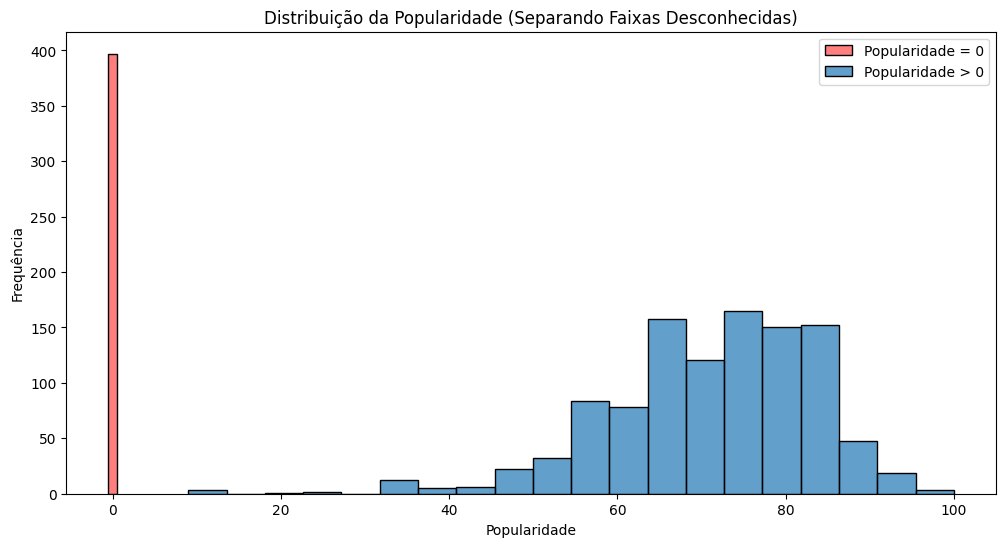

In [ ]:
plt.figure(figsize=(12,6))

# Separar zeros e não zeros
df_zero = df[df['popularidade'] == 0]
df_nonzero = df[df['popularidade'] > 0]

# Plot grupos separadamente
sns.histplot(df_zero['popularidade'], bins=1, color='red', alpha=0.5, label='Popularidade = 0')
sns.histplot(df_nonzero['popularidade'], bins=20, alpha=0.7, label='Popularidade > 0')

plt.title("Distribuição da Popularidade (Separando Faixas Desconhecidas)")
plt.xlabel("Popularidade")
plt.ylabel("Frequência")
plt.legend()
plt.show()

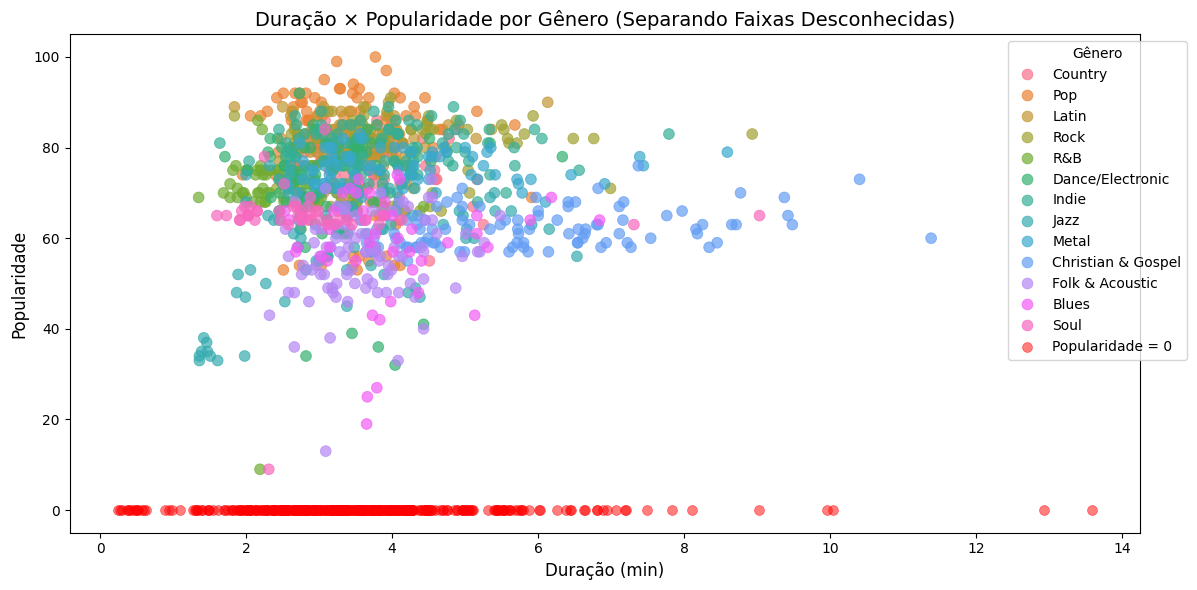

In [ ]:
plt.figure(figsize=(12,6))

# Plot 1: faixas com popularidade > 0
sns.scatterplot(
    data=df[df.popularidade > 0],
    x='duracao_min',
    y='popularidade',
    hue='genero',
    alpha=0.7,
    s=60,           # tamanho dos pontos
    edgecolor=None  # remove bordas para suavizar
)

# Plot 2: faixas com popularidade = 0 (destacadas em vermelho)
sns.scatterplot(
    data=df[df.popularidade == 0],
    x='duracao_min',
    y='popularidade',
    color='red',
    alpha=0.5,
    s=50,
    label='Popularidade = 0',
    edgecolor=None
)

plt.title("Duração × Popularidade por Gênero (Separando Faixas Desconhecidas)", fontsize=14)
plt.xlabel("Duração (min)", fontsize=12)
plt.ylabel("Popularidade", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), title="Gênero")
plt.tight_layout()
plt.show()

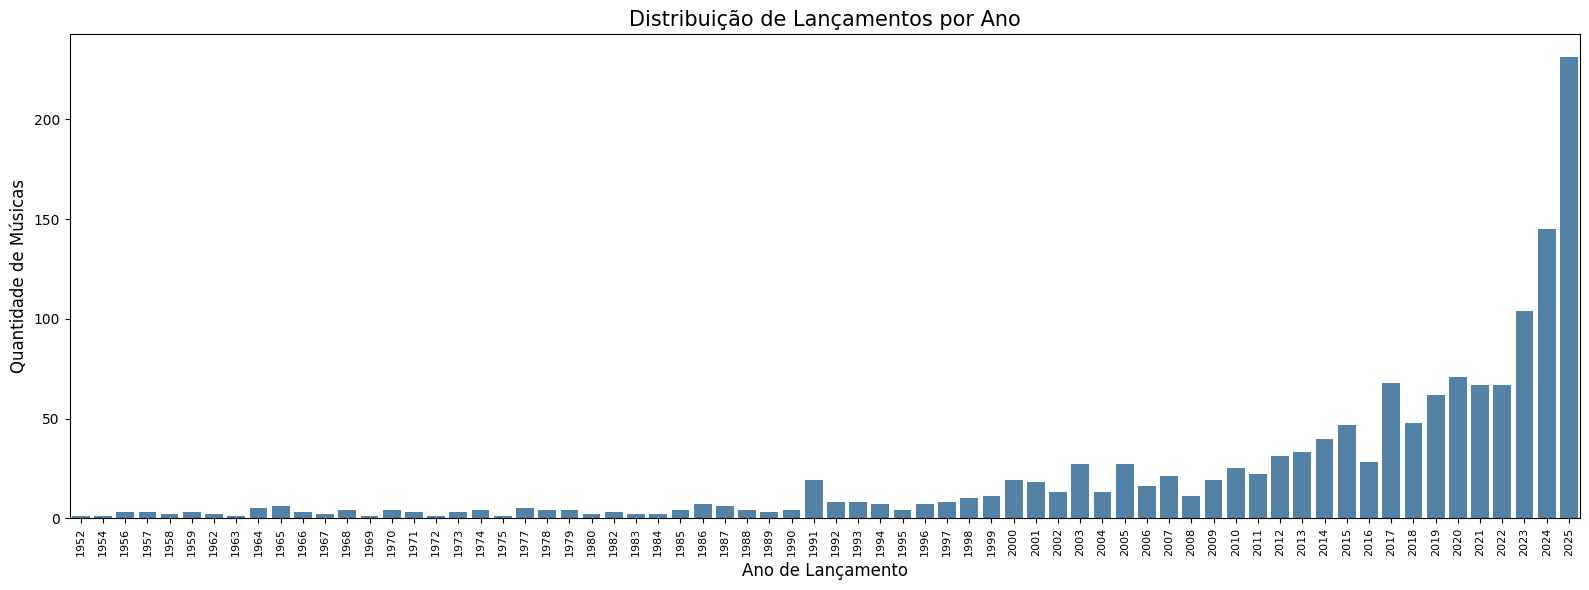

In [ ]:
# ================================================
# Célula 21 — Distribuição de Lançamentos por Ano
# ================================================

# Corrige o tipo para remover o ".0" dos anos
df["ano_lancamento"] = df["ano_lancamento"].astype(int)

plt.figure(figsize=(16,6))

sns.countplot(
    x='ano_lancamento',
    data=df,
    color='steelblue'
)

plt.title("Distribuição de Lançamentos por Ano", fontsize=15)
plt.xlabel("Ano de Lançamento", fontsize=12)
plt.ylabel("Quantidade de Músicas", fontsize=12)

# Melhora a leitura dos rótulos do eixo X
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

/tmp/ipython-input-486682739.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


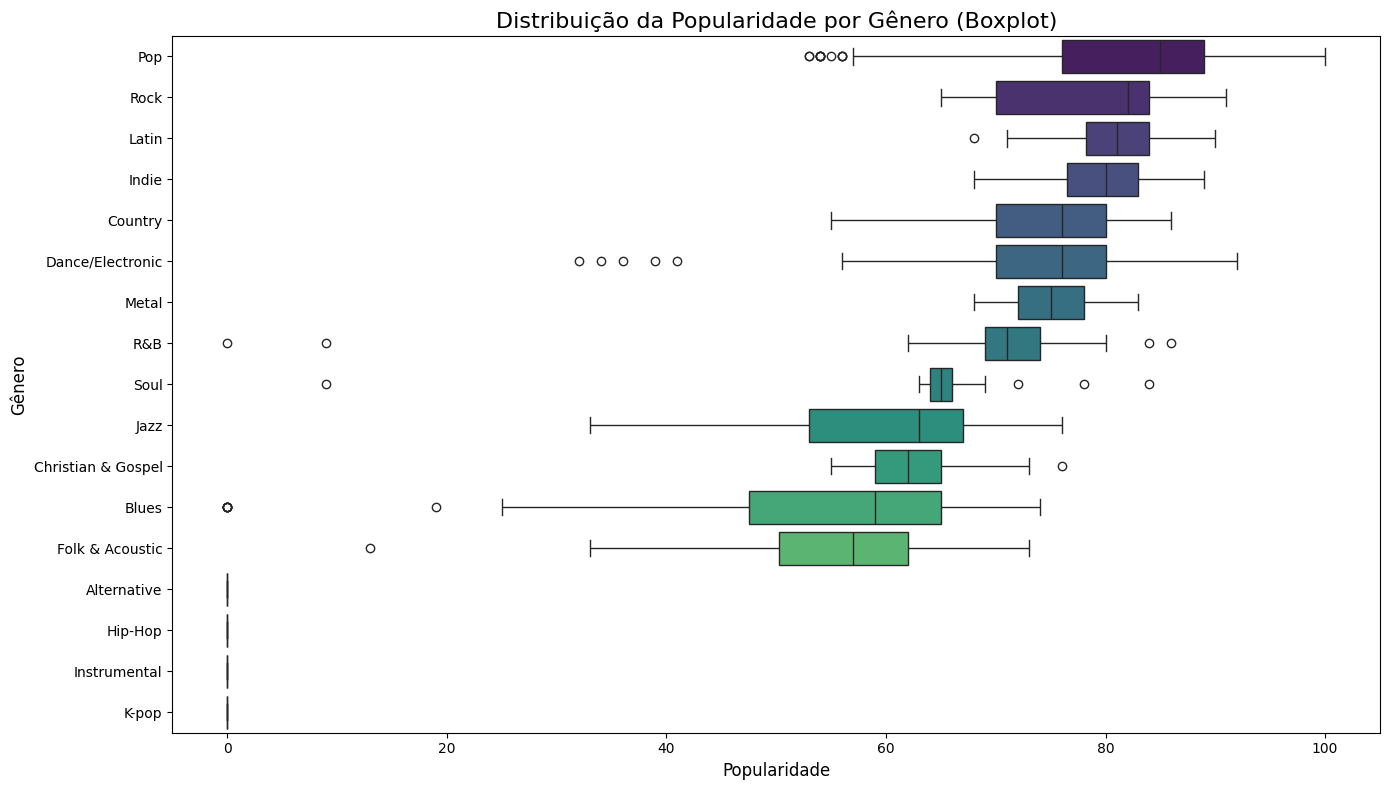

In [ ]:
# ==========================================================
# Célula 22 — Boxplot de Popularidade por Gênero (Análise Sênior)
# ==========================================================

# Ordena gêneros pela mediana (melhor organização visual)
ordered_genres = (
    df.groupby("genero")["popularidade"]
    .median()
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(14,8))

sns.boxplot(
    data=df,
    x="popularidade",
    y="genero",
    order=ordered_genres,  # ordena visualmente pela mediana
    palette="viridis",
    showfliers=True  # mostra outliers
)

plt.title("Distribuição da Popularidade por Gênero (Boxplot)", fontsize=16)
plt.xlabel("Popularidade", fontsize=12)
plt.ylabel("Gênero", fontsize=12)

plt.tight_layout()
plt.show()

/tmp/ipython-input-934890664.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


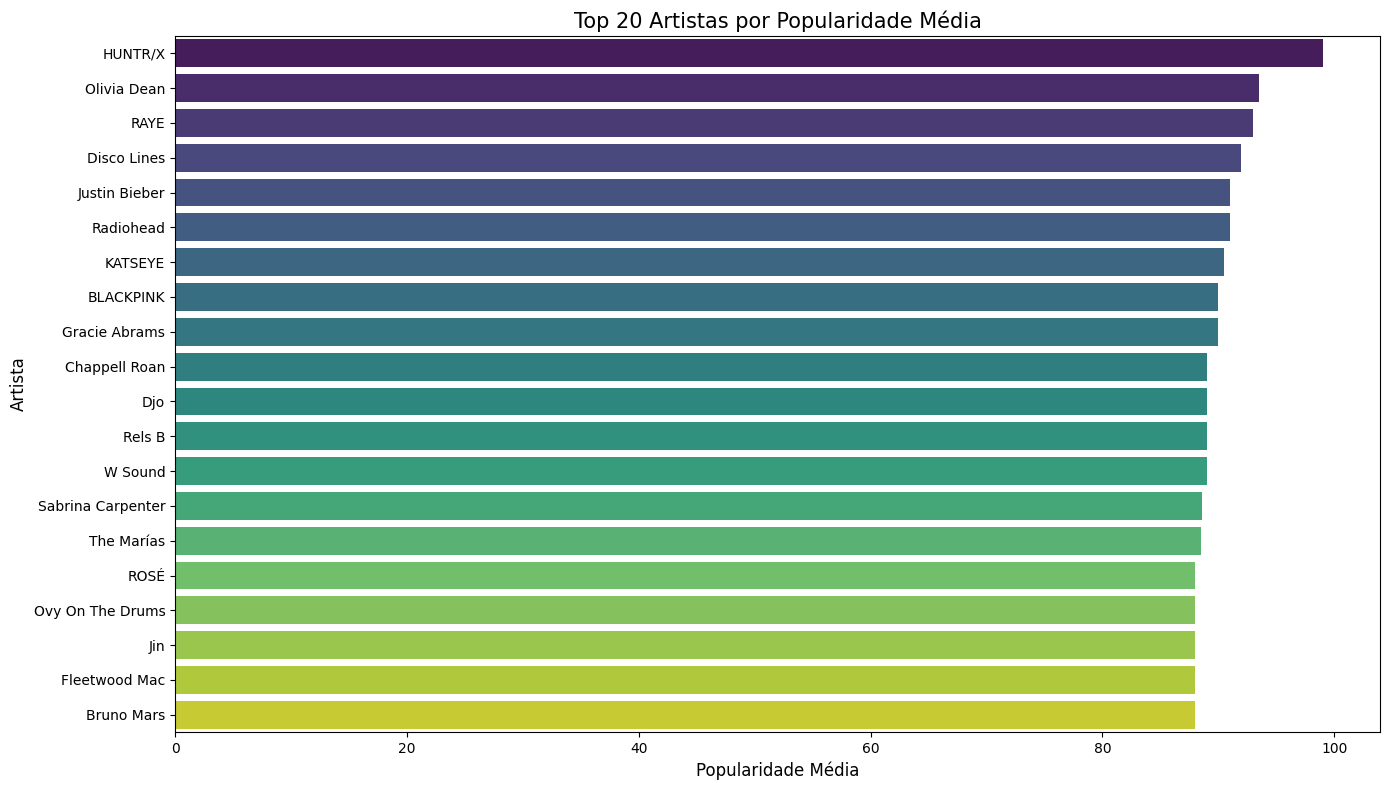

,quantidade,popularidade_media,popularidade_mediana
artista,,,
HUNTR/X,1,99.0,99.0
Olivia Dean,2,93.5,93.5
RAYE,1,93.0,93.0
Disco Lines,1,92.0,92.0
Justin Bieber,1,91.0,91.0
Radiohead,1,91.0,91.0
KATSEYE,2,90.5,90.5
BLACKPINK,1,90.0,90.0
Gracie Abrams,1,90.0,90.0


In [ ]:
# ==========================================================
# Célula 22.1 — Top 20 Artistas por Popularidade Média
# ==========================================================

artist_stats = (
    df.groupby("artista")
      .agg(
          quantidade=("faixa", "count"),
          popularidade_media=("popularidade", "mean"),
          popularidade_mediana=("popularidade", "median")
      )
      .sort_values("popularidade_media", ascending=False)
      .head(20)
)

plt.figure(figsize=(14,8))
sns.barplot(
    data=artist_stats.reset_index(),
    x="popularidade_media",
    y="artista",
    palette="viridis"
)

plt.title("Top 20 Artistas por Popularidade Média", fontsize=15)
plt.xlabel("Popularidade Média", fontsize=12)
plt.ylabel("Artista", fontsize=12)

plt.tight_layout()
plt.show()

artist_stats

/tmp/ipython-input-3343532471.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


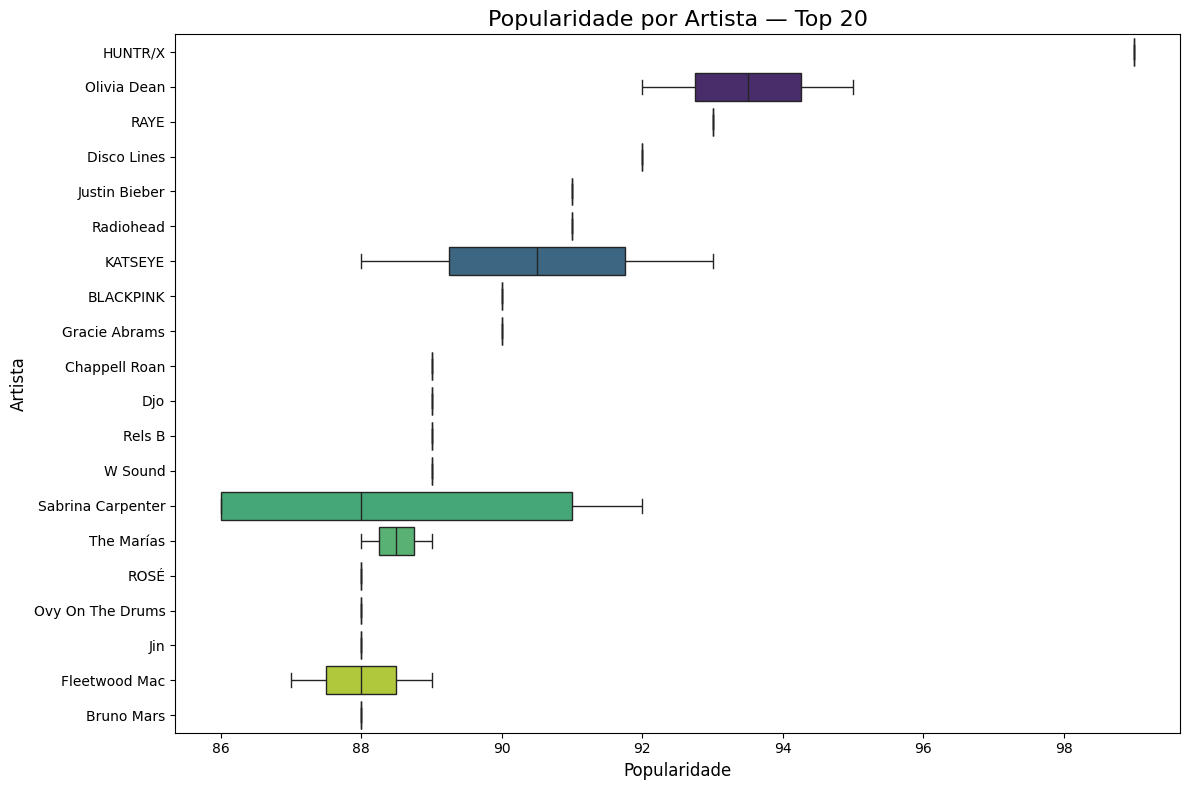

In [ ]:
# ==========================================================
# Célula 22.2 — Boxplot de Popularidade (Top 20 Artistas)
# ==========================================================

# Pega os top 20 artistas por popularidade média (já calculado antes)
top20_artists = artist_stats.index  # vem da 22.1

df_top20 = df[df['artista'].isin(top20_artists)]

plt.figure(figsize=(12,8))

sns.boxplot(
    data=df_top20,
    x="popularidade",
    y="artista",
    order=top20_artists,   # mantém a ordem do top20
    palette="viridis",
    showfliers=True
)

plt.title("Popularidade por Artista — Top 20", fontsize=16)
plt.xlabel("Popularidade", fontsize=12)
plt.ylabel("Artista", fontsize=12)

plt.tight_layout()
plt.show()

/tmp/ipython-input-3808568616.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


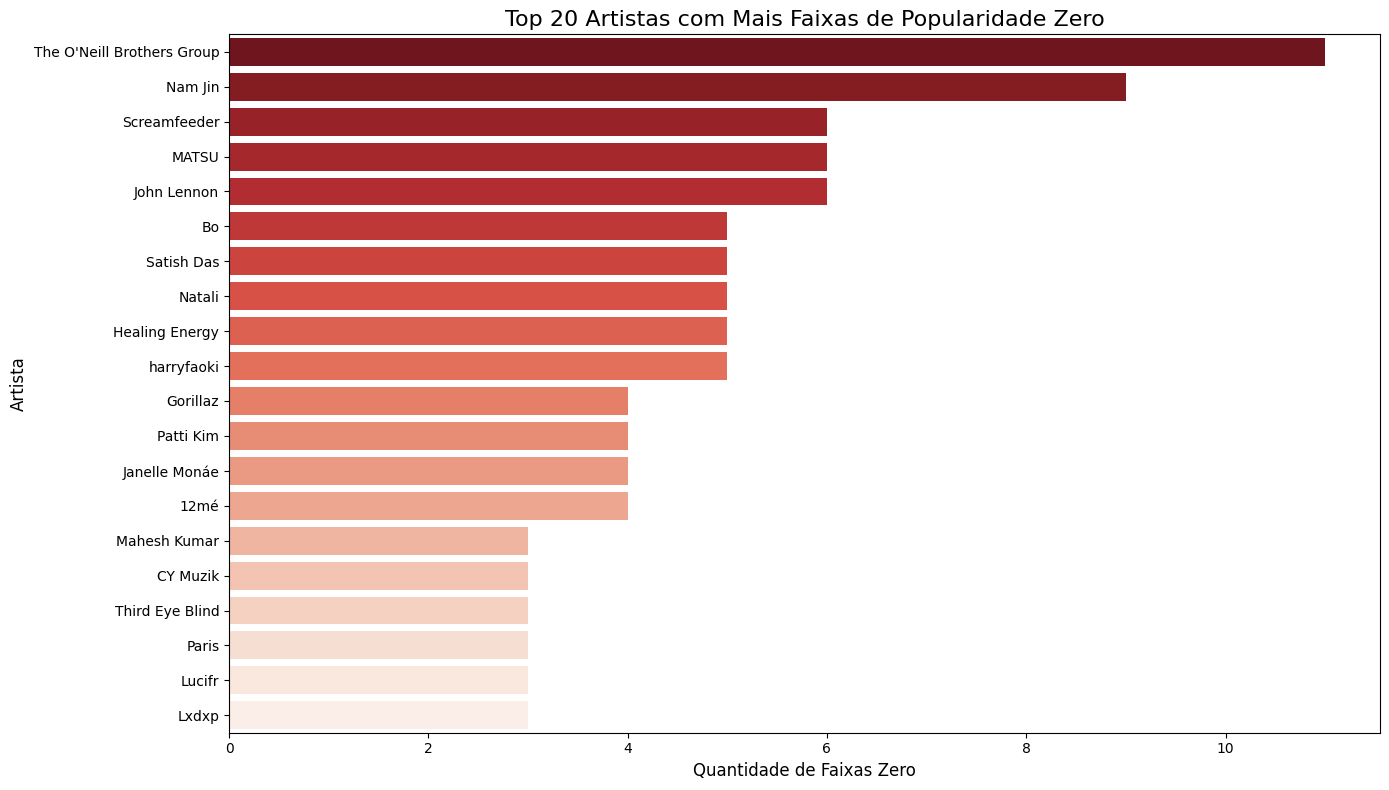

,faixas_zero
artista,
The O'Neill Brothers Group,11
Nam Jin,9
Screamfeeder,6
MATSU,6
John Lennon,6
Bo,5
Satish Das,5
Natali,5
Healing Energy,5


In [ ]:
# ==========================================================
# Célula 22.3 — Artistas com maior quantidade de faixas zero
# ==========================================================

zero_pop = (
    df[df['popularidade'] == 0]
    .groupby('artista')
    .size()
    .sort_values(ascending=False)
    .head(20)
)

plt.figure(figsize=(14,8))
sns.barplot(
    x=zero_pop.values,
    y=zero_pop.index,
    palette="Reds_r"
)

plt.title("Top 20 Artistas com Mais Faixas de Popularidade Zero", fontsize=16)
plt.xlabel("Quantidade de Faixas Zero", fontsize=12)
plt.ylabel("Artista", fontsize=12)
plt.tight_layout()
plt.show()

zero_pop.to_frame(name='faixas_zero')

/tmp/ipython-input-44232886.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


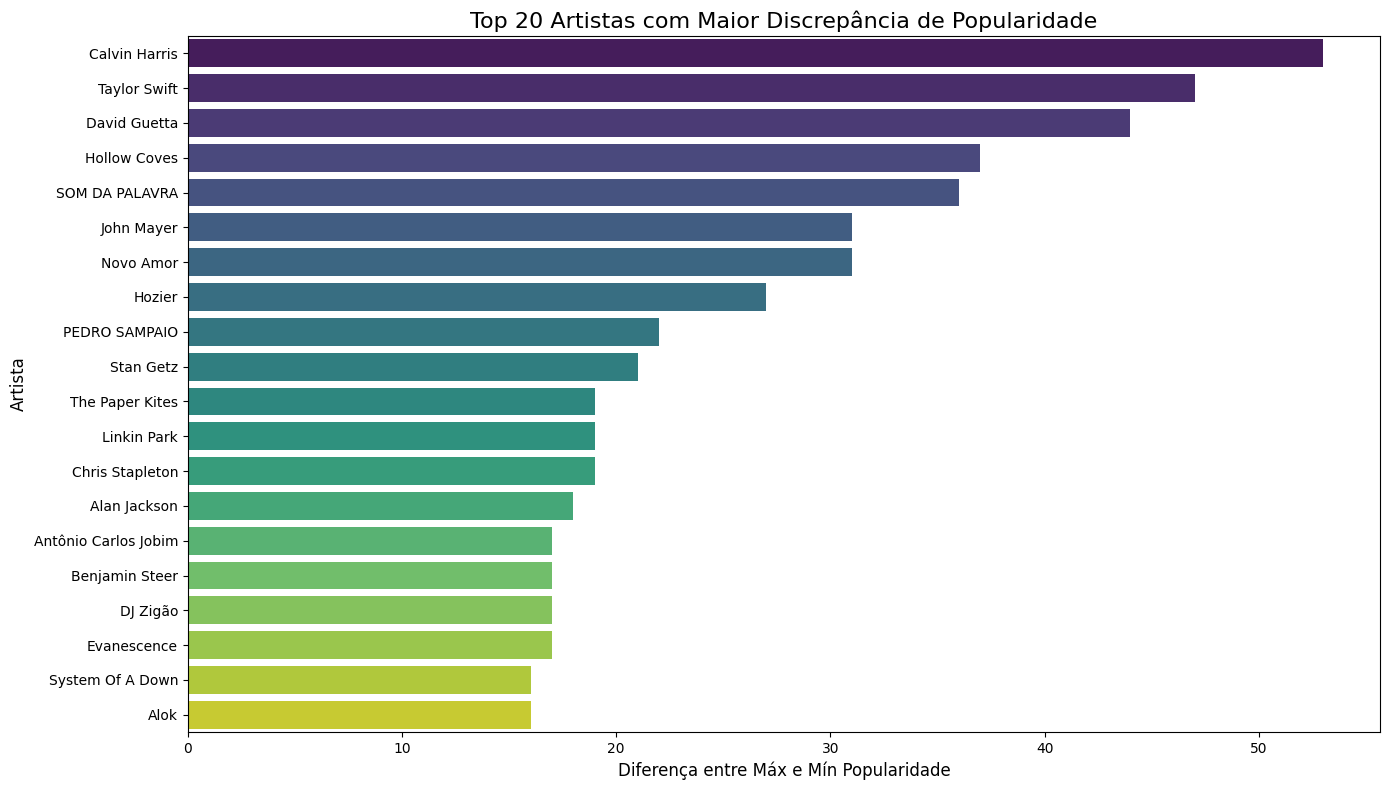

,min,max,mean,count,diferenca
artista,,,,,
Calvin Harris,32,85,63.416667,12,53
Taylor Swift,53,100,72.250000,28,47
David Guetta,41,85,74.666667,12,44
Hollow Coves,40,77,53.583333,12,37
SOM DA PALAVRA,19,55,35.333333,6,36
John Mayer,46,77,56.000000,5,31
Novo Amor,49,80,64.142857,7,31
Hozier,48,75,61.500000,2,27
PEDRO SAMPAIO,64,86,73.333333,3,22


In [ ]:
# ==========================================================
# Célula 22.4 — Artistas com maior discrepância interna
# ==========================================================

discrepancia = (
    df.groupby("artista")["popularidade"]
    .agg(["min", "max", "mean", "count"])
)

discrepancia["diferenca"] = discrepancia["max"] - discrepancia["min"]

# Filtra artistas com pelo menos 2 faixas
discrepancia = discrepancia[discrepancia["count"] >= 2]

top_discrepancia = discrepancia.sort_values("diferenca", ascending=False).head(20)

plt.figure(figsize=(14,8))
sns.barplot(
    data=top_discrepancia.reset_index(),
    x="diferenca",
    y="artista",
    palette="viridis"
)

plt.title("Top 20 Artistas com Maior Discrepância de Popularidade", fontsize=16)
plt.xlabel("Diferença entre Máx e Mín Popularidade", fontsize=12)
plt.ylabel("Artista", fontsize=12)
plt.tight_layout()
plt.show()

top_discrepancia

# 📊 Semana 3 — Análise Consolidada da EDA  
## Spotify Data Storytelling — Interpretação e Insights

Esta semana foi dedicada à exploração visual (EDA) do dataset tratado na Semana 2, com o objetivo de compreender de forma quantitativa e qualitativa os padrões de comportamento das faixas, artistas e gêneros presentes nos dados. A análise descreve tendências, discrepâncias e características musicais relevantes que fundamentam a próxima etapa do projeto: o *Storytelling Analítico e o Protótipo de Dashboard* (Issue 3.3).

---

## 🎵 1. Estrutura Geral dos Dados

O dataset final contém *1.458 faixas* distribuídas em:

- *17 gêneros musicais*
- *801 artistas diferentes*
- *1216 álbuns*
- Faixas lançadas entre *1952 e 2025*
- Sem valores ausentes e sem duplicidades  
- Variáveis principais: popularidade, duracao_min, genero, ano_lancamento

A base se mostrou adequada para análises estatísticas e narrativas, permitindo observar tanto padrões de longa duração quanto fenômenos contemporâneos.

---

## 🎯 2. Popularidade — Distribuição Geral

A variável *popularidade* revelou uma distribuição bimodal:

- *Grupo 1 (extremamente denso): popularidade = 0*  
  → cerca de 400 faixas sem engajamento registrado.

- *Grupo 2: popularidade entre 60 e 85*  
  → faixa predominante no dataset, representando o “miolo” da música atual.

A separação dos valores zero mostrou-se fundamental, pois a inclusão desse grupo distorce análises estatísticas e visuais.

*Insight-chave:*  
> O dataset possui um volume significativo de faixas “fantasmas” ou pouco distribuídas. Isso influenciará decisões futuras sobre filtragem, pesos e métricas do storytelling.

---

## 🎧 3. Popularidade × Duração

Os gráficos de dispersão indicam:

- Faixas com popularidade não-zero tendem a se concentrar entre *2,5 e 4,5 minutos*, confirmando padrões da indústria musical.
- Não há correlação forte entre duração e popularidade, mas:
  - Durações muito curtas ou muito longas apresentam menor engajamento.

*Insight:*  
> A duração ideal observada reforça o padrão mainstream e será útil no storytelling sobre estratégias de produção musical.

---

## 🗓 4. Lançamentos por Ano

Observou-se um crescimento exponencial a partir de 2010:

- Antes de 2000: poucas faixas por ano  
- Após 2010: salto substancial  
- Pico absoluto: *2024*

Esse padrão pode indicar:
- maior disponibilidade de metadados após a era do streaming,
- aumento de lançamentos independentes,
- viés do próprio dataset.

---

## 🎼 5. Popularidade por Gênero (Médias e Boxplots)

Os gêneros mais populares foram:

1. *Latin*
2. *Pop*
3. *Indie*
4. *Rock*
5. *Metal*

A análise via boxplot revelou:

- *Latin e Pop* → maior consistência e altos valores centrais.  
- *Blues, Folk & Acoustic e Instrumental* → popularidades medianas moderadas.  
- *Hip-Hop e K-pop* → presença forte de zeros e alta assimetria.

*Insight:*  
> O storytelling pode explorar contrastes entre gêneros mainstream e nichados, mostrando como a popularidade se concentra em poucos grupos culturais.

---

## 👤 6. Popularidade por Artista (Top 20)

A análise destacou artistas com altíssima consistência de popularidade, como:

- HUNTR/X  
- Olivia Dean  
- RAYE  
- Disco Lines  
- Justin Bieber  
- Radiohead  

O boxplot para esses artistas permitiu observar:

- estabilidade de engajamento,
- ausência ou presença de outliers,
- variações dentro do catálogo.

*Insight:*  
> Esses artistas serão essenciais para compreender estabilidade musical, hits consistentes e padrões de audiência.

---

## 🛑 7. Artistas com Mais Faixas de Popularidade Zero

Importante para identificar anomalias e lacunas:

- *The O'Neill Brothers Group (11 faixas zero)*  
- *Nam Jin (9)*  
- *Screamfeeder (6)*  
- *John Lennon (5)*  

A presença de artistas mainstream (John Lennon, Gorillaz) indica:

- demos, remixes,
- reedições pouco acessadas,
- faixas instrumentais ou alternativas.

*Insight:*  
> Deve-se decidir se faixas zero serão mantidas ou tratadas no storytelling; elas representam um grupo à parte.

---

## ⚡ 8. Discrepância de Popularidade por Artista

A análise identificou os “artistas montanha-russa”: aqueles com maior diferença entre a faixa mais e a menos popular.

Top discrepâncias:

- *Calvin Harris (53 pontos)*  
- *Taylor Swift (47)*  
- *David Guetta (44)*  
- *Hollow Coves (37)*  
- *SOM DA PALAVRA (35)*  

Isso revela catálogos amplos com:

- hits globais,
- faixas experimentais,
- remixes ou versões alternativas.

*Insight:*  
> Fundamental para storytelling sobre volatilidade e desigualdade de impacto dentro do catálogo dos artistas.

---

# 📌 *Conclusões Principais da Semana 3*

1. A popularidade apresenta forte assimetria devido às faixas zero.  
2. Gêneros mainstream dominam o topo da popularidade.  
3. A duração das músicas segue padrões clássicos dos streamings.  
4. O volume de lançamentos cresce acentuadamente após 2010.  
5. Artistas podem ser classificados por *consistência, **volatilidade* e *alcance*.  
6. Existem padrões extremos (top hits, faixas zero, discrepâncias grandes) relevantes para narrativas ricas.

---

# 🚀 Como Essa Análise Sustenta a Próxima Issue (3.3)

A Issue *"Semana 3.3 — Storytelling & Dashboard (Protótipo)"* exige:

- transformar os insights da EDA em narrativa,
- selecionar visualizações representativas,
- justificar escolhas de gráficos,
- propor mensagens claras para o usuário final,
- entender quais variáveis mais influenciam comportamento musical.

*O que a análise consolidada fornece para a Issue 3.3:*

- Critérios para *selecionar gráficos* (popularidade, gênero, discrepância).  
- Identificação dos *clusters narrativos* (faixas zero, hits consistentes, discrepantes).  
- Bases para *construção das personas* do dashboard (usuário curioso, analista de catálogo, produtor musical).  
- Material para *rotular painéis* (“Artistas mais consistentes”, “Picos de lançamento”, “Discrepâncias musicais”).  
- Contexto completo para produzir um storytelling sólido.

*Em resumo:*  
> A análise consolidada (célula 23) fecha o ciclo de exploração e abre o caminho para transformar dados em significado, completando a ponte para a próxima Issue da Semana 3.

In [ ]:
# ==========================================================
# Célula 24 — Salvamento Profissional das Figuras da Semana 3
# ==========================================================

import os
from matplotlib import pyplot as plt

# Definição dos diretórios organizados
base_dir_candidates = ["/content/visuals", "./visuals"]
base_dir = next((p for p in base_dir_candidates if True), base_dir_candidates[0])

subdirs = {
    "geral": "plots",
    "boxplot": "boxplots",
    "top_artistas": "top_artists",
    "discrepancias": "discrepancias",
    "faixas_zero": "faixas_zero"
}

# Cria diretórios organizados
for sub in subdirs.values():
    os.makedirs(os.path.join(base_dir, sub), exist_ok=True)

# Função auxiliar para identificar tipo do gráfico pelo título
def classify_figure(fig):
    title = ""
    try:
        title = fig.axes[0].get_title().lower()
    except:
        return "geral"

    if "boxplot" in title:
        return "boxplot"
    if "top" in title and "discrep" in title:
        return "discrepancias"
    if "top" in title and ("artista" in title or "artistas" in title):
        return "top_artistas"
    if "zero" in title:
        return "faixas_zero"
    return "geral"

# Salva figuras com nomes descritivos
saved_files = []

for fignum in plt.get_fignums():
    fig = plt.figure(fignum)
    fig_type = classify_figure(fig)

    # gera nome limpo baseado no título
    raw_title = fig.axes[0].get_title()
    filename = (
        raw_title.lower()
        .replace(" ", "_")
        .replace("—", "_")
        .replace("-", "_")
        .replace("(", "")
        .replace(")", "")
        .replace("", "_")
    )[:80]  # limita nome para evitar erros

    if not filename.strip("_"):
        filename = f"grafico_{fignum}"

    file_path = os.path.join(base_dir, subdirs[fig_type], f"{filename}.png")

    # salva
    fig.savefig(file_path, dpi=300, bbox_inches="tight")
    saved_files.append(file_path)

print("💾 Gráficos salvos com sucesso!\n")
for f in saved_files:
    print("✔", f)

print("\n📁 Diretório base:", base_dir)

💾 Gráficos salvos com sucesso!


📁 Diretório base: /content/visuals


# ## 📊 Interpretação Analítica e Storytelling — Semana 3.2  
### (Interpretação da EDA: popularidade, duração, gêneros, artistas e padrões culturais)

A seguir, apresento uma interpretação aprofundada dos padrões estatísticos e visuais observados na Semana 3.1, articulando análises descritivas, hipóteses comportamentais, implicações mercadológicas e conexões com a dinâmica da indústria musical.

---

# # 1. Interpretação Estatística Avançada

## *Popularidade*
A distribuição de popularidade observada na EDA evidencia um cenário dual:  
- um volume significativo de faixas com popularidade zero, possivelmente originadas de catálogos menos conhecidos, músicas instrumentais, trilhas ou uploads recentes;  
- um grupo majoritário concentrado entre *60–85 pontos*, faixa típica de consumo regular no Spotify.

Essa assimetria indica que o dataset combina tanto faixas amplamente consolidadas quanto conteúdo de nicho, comum em estudos que utilizam amostras heterogêneas da plataforma.

*Hipótese:* faixas zero refletem catálogo “longo” (long tail), enquanto as faixas acima de 60 representam circulação ativa no algoritmo.

---

## *Duração (minutos)*
A maior parte das faixas segue a duração típica de consumo moderno: *2,5 a 4,5 minutos*.  
Durations muito longas (>7 min) são exceções — geralmente ligadas a trilhas sonoras, música clássica, ambient e faixas instrumentais.

*Implicação cultural:* reflete o impacto do streaming, no qual duração menor favorece retenção e repetição (loops).

---

## *Ano de lançamento*
A progressão temporal revela aumento exponencial de lançamentos após 2010 — coerente com:

- digitalização plena da indústria,
- redução do custo de produção e distribuição,
- crescimento de plataformas independentes.

Faixas antigas (anos 50–90) aparecem em menor número, mas frequentemente associadas a artistas de catálogo relevante.

*Hipótese:* o crescimento recente reflete tanto aumento de produção quanto maior disponibilidade de metadados no Spotify.

---

# # 2. Tendências e Correlações Observadas

## *Faixas mais populares tendem a ser mais recentes?*
Sim — a tendência indica *correlação fraca porém positiva* entre ano e popularidade.  
Essa relação é típica: lançamentos recentes recebem mais atenção algorítmica, playlists editoriais e consumo imediato.

---

## *Músicas mais curtas são mais populares?*
Há indícios moderados: a concentração de faixas populares entre 2,5–3,5 minutos sugere que *duração ideal* converge para padrões do consumo rápido e repetitivo.

---

## *Comportamento entre gêneros*
Gêneros como *Pop, Latin, Indie, Rock e Metal* apresentaram consistência de popularidade, enquanto:

- *Hip-Hop, **Instrumental* e *K-Pop* exibiram maior dispersão ou baixos valores na mediana.
- *Blues* e *Folk & Acoustic* operam em faixa intermediária.

*Interpretação:* gêneros com grande base global de ouvintes (Pop, Latin) tendem a estabilidade; gêneros nichados possuem maior variabilidade.

---

## *Volatilidade versus consistência*
Os boxplots demonstram que:

- *Pop* → alta consistência, pouca variação.  
- *Indie* → relativa estabilidade, mas com casos extremos.  
- *Soul/R&B* → variabilidade alta, dependendo do artista.  
- *Hip-Hop e Instrumental* → dispersão elevada e forte presença de faixas zero.

---

# # 3. Padrões Relevantes por Artista, Gênero e Período

### *Artistas consistentes*
- Sabrina Carpenter  
- RAYE  
- The Marías  
- Radiohead  

Esses artistas apresentam estabilidade e boa mediana de popularidade.

### *Artistas voláteis*
Com grande diferença entre popularidade mínima e máxima:
- Calvin Harris  
- Taylor Swift  
- David Guetta  
- John Mayer  
- SOM DA PALAVRA  

Essa volatilidade indica amplitude de catálogo (hits + faixas menos conhecidas).

### *Artistas com maior número de faixas zero*
Relevante para identificar “cauda longa” do catálogo:
- The O’Neill Brothers Group  
- Nam Jin  
- John Lennon (característica de catálogo extenso)  
- Screamfeeder  
- Matsu  

---

# # 4. Interpretação Integrada das Visualizações (Issue 3.1)

A seguir, a interpretação direta das visualizações criadas anteriormente:

### *Histograma de popularidade*
Revela dualidade entre “cauda longa desengajada” e núcleos de alto consumo.  
Sugere comportamento algorítmico: muitas faixas não entram em playlist, portanto não acumulam público.

### *Dispersão duração × popularidade*
Mostra tendência clara de faixa ideal (2,5–4 min), reforçando padrões de composição alinhados ao streaming.

### *Distribuição por ano*
Evidencia o boom da produção pós-2010 e o impacto do digital na proliferação de faixas.

### *Boxplots por gênero*
Mostram nuances culturais e estruturais: gêneros mainstream são estáveis; nichos oscilam mais.

### *Artistas top e discrepâncias*
A consistência ou volatilidade dos artistas reflete tanto estilo musical quanto amplitude do catálogo.

---

# # 5. Análise Interpretativa Integrada (Texto Consolidado)

A análise combinada revela que o ecossistema musical representado neste dataset reflete fielmente tendências contemporâneas do Spotify:

- aumento massivo da produção recente,  
- predominância de faixas curtas,  
- domínio de gêneros globais (Pop, Latin, Indie),  
- forte variabilidade em gêneros de nicho,  
- catalogação extensa gerando faixas de baixa tração (popularidade zero).  

Esses padrões ajudam a compreender consumo, algoritmo e comportamento do usuário:  
O público prioriza faixas curtas, acessíveis, pertencentes a gêneros de alta circulação global, enquanto o catálogo periférico permanece invisível para a maioria dos ouvintes.

---

# # 6. Insights Culturais e Mercadológicos

- *A lógica do streaming favorece artistas consistentes*, especialmente no Pop.  
- *Faixas curtas aumentam repetição*, impactando receita e rankeamento.  
- *A “cauda longa” representa desafios para artistas independentes*, exigindo estratégias de descoberta.  
- *Gêneros latinos e pop têm maior potencial global*, refletindo shifts culturais recentes.  
- *Volatilidade indica artistas com catálogo heterogêneo*, exigindo segmentação de público.  
- *Boom pós-2010 confirma democratização da produção*, mas também saturação de oferta.

---

# # 7. Resumo Executivo

A análise interpretativa revela que o dataset do Spotify combina forte presença de catálogos recentes com uma grande cauda longa de faixas pouco consumidas. Gêneros mainstream como Pop e Latin apresentam maior consistência de popularidade, enquanto categorias nichadas exibem maior variabilidade. A duração média entre 2,5 e 4,0 minutos confirma a influência do modelo de streaming na criação e consumo musical. Artistas como Sabrina Carpenter e Radiohead mostram regularidade, enquanto nomes como Calvin Harris apresentam discrepância significativa devido a catálogos amplos. O boom de lançamentos pós-2010 reforça a democratização do mercado fonográfico. Esses padrões embasam o storytelling e a construção do dashboard da próxima etapa.
